<a href="https://colab.research.google.com/github/lindsay0924/Camino-Financial-s-Data-Engineering-Take-Home-Project/blob/master/robinhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

##Load the data

In [2]:
data1 = pd.read_csv('/content/delta_price_symbols_A_to_D.csv', header = 0)
data2 = pd.read_csv('/content/delta_price_symbols_E_to_H.csv', header = 0)
data3 = pd.read_csv('/content/delta_price_symbol_X.csv', header = 0)

##Data Cleansing

In [3]:
data1 = data1.drop(['Date','Unnamed: 0'], axis = 1)
data2 = data2.drop(['Date','Unnamed: 0'], axis = 1)
data3 = data3.drop(['Date','Unnamed: 0'], axis = 1)
data = pd.concat([data1, data2, data3], axis = 1)

X, y = data.drop(['delta_price_X'], axis = 1), data.delta_price_X

##Data preprocessing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

##Fit regression model

In [5]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

print("Model Accuracy: %.3f" % reg.score(X_test, y_test))

The mean squared error (MSE) on test set: 0.0283
Model Accuracy: -0.153


##Calculate the coefficient and intercept

In [6]:
l = len(X_test.iloc[0])
coef = []
test = [0]*l
intercept = reg.predict(np.array(test).reshape(1,-1))
for i in range(l):
  test = [0]*l
  test[i] = 1
  coef_i = reg.predict(np.array(test).reshape(1,-1)) - intercept
  rounded_coef_i = round(coef_i[0],4)
  coef.append(rounded_coef_i)
print('The intercept is :{}'.format(intercept))
print('The coefficients are :{}'.format(coef))   

The intercept is :[0.03505496]
The coefficients are :[0.0717, -0.0102, 0.0198, 0.0304, 0.0176, 0.014, -0.0781, 0.045]


##Plot training deviance

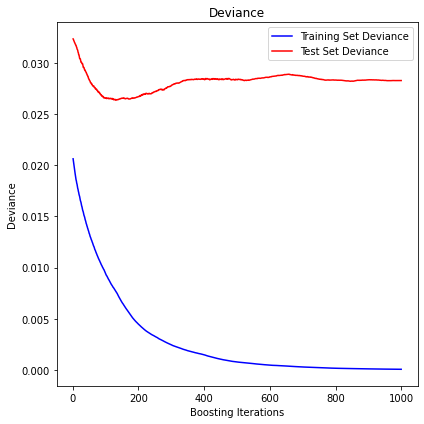

In [7]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

##Plot feature importance

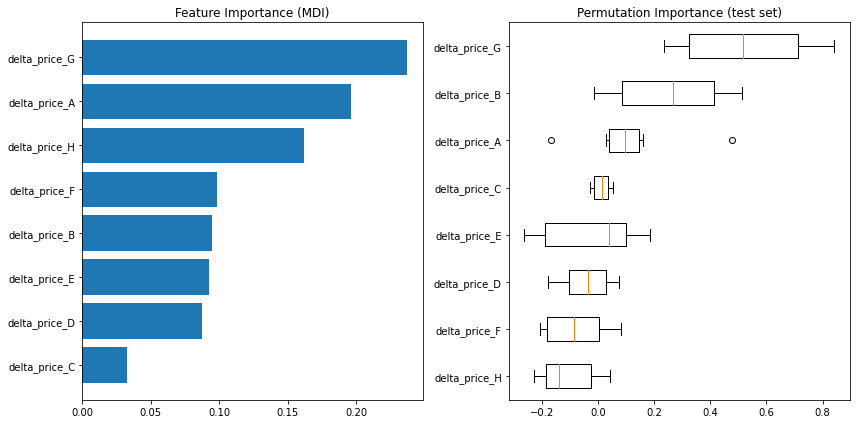

In [8]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

##Detect Multicolinearity

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data.sort_values('VIF'))

         feature        VIF
4  delta_price_E  13.405753
1  delta_price_B  15.690421
5  delta_price_F  16.075372
6  delta_price_G  17.317676
0  delta_price_A  17.636775
2  delta_price_C  18.473310
3  delta_price_D  27.714634
7  delta_price_H  31.038473


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
